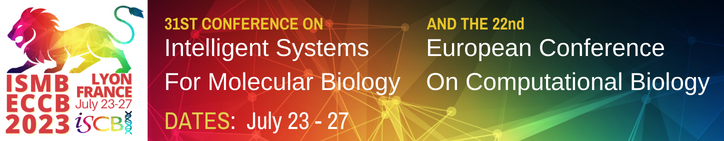

#**VT2: Protein Sequence Analysis using Transformer-based Large Language Model**

### **Part-2A : How to use a pre-trained Transformer Model for generating sequence embeddings**

31st Conference on Intelligent Systems for Molecular Biology (ISMB) /
22nd European Conference on Computational Biology (ECCB)

**Venue:** Hybrid (Virtual/Lyon,France)

**Date of the session:** July 17-18, 2023

**Instructor :** Bishnu Sarker, PhD

**Affiliation :** Meharry Medical College School of Applied Computational Sciences, Tennessee, USA


Please cite this tutorial as:

**Bishnu Sarker, Sayane Shome, Farzana Rahman, Nima Aghaeepour (2023, July). Tutorial VT2: Protein Sequence Analysis using Transformer-based Large Language Model. In 31st Conference on Intelligent Systems for Molecular Biology and 22nd European Conference on Computational Biology (ISMB/ECCB 2023), Lyon, France.**

RNNs (Recurrent Neural Networks) and LSTMs (Long Short-Term Memory networks) possess a remarkable capability to model sequential data and capture spatial dependencies. They have been widely utilized as go-to deep learning models for tasks involving sequence data, such as text classification. However, one limitation of traditional LSTMs is their inability to attend to different parts of the input sentence simultaneously.

In certain classification tasks, it becomes essential to associate different sections of the input sequence with one another. By doing so, we can unveil important patterns and relationships that describe the connection between the sequence and the corresponding label.

To address this limitation, more advanced models and architectures have been developed, such as the attention mechanism. Attention-based models allow for the dynamic allocation of attention weights to different parts of the input sequence, enabling the model to focus on the most relevant and informative elements. By incorporating attention mechanisms, we can enhance the model's ability to capture intricate patterns and dependencies, leading to improved performance in tasks requiring sequence classification.

By leveraging attention mechanisms, we can unlock the potential to discover crucial associations between various parts of the input sequence, thereby enhancing the model's comprehension and representation of the underlying relationships.

The researches published in [( Bahdanau et al., 2014)](https://arxiv.org/pdf/1409.0473.pdf) and [( Luong et al., 2015.)](https://arxiv.org/pdf/1508.04025.pdf) introduced attention mechanism  roughly a decade ago. Following that progress, in 2017 a team of googe researchers first developed the Transformer architecture published as ["Attention is All You Need"](https://arxiv.org/pdf/1706.03762.pdf) that uses multiple attentions (aka multi-head attention). A visual description of the attention mechanism is available [here](https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/) and a much detail explanation [here](https://towardsdatascience.com/transformers-explained-visually-part-1-overview-of-functionality-95a6dd460452). Transformers are a encoder-decoder model designed to perform multitudes of sequence modeling tasks such as classification, translations, learning representaitons etc.



The hands-on in Part 1B and Part 1C showed how to implement RNN and LSTM for a sequence classification task. Transformers are resource intensive model in a sense that they require powerful machines and gpus to train. Therefore, it is not feasible to train a new model for every task. There is the concept of pre-training emerges that perform the transfer learning. The model is pre-trained using a resource rich computing facility. The model architecture with pre-trained parameters are shared with the public. The pre-trained models are then used to build other models for many downstream tasks.

In this hands-on, the objectives are:
1. Load a pre-trained transformer model trained on millions of protein sequences from UniProtKB.
2. Generate the embeddings for a list of sequences.

####**SECTION 1 : Loading a pre-trained transformer model trained on millions of protein sequences.**

Before moving forward, this hands-on requires you to include GPU in the runtime. This can be done by following:


***Colab Menu-->Runtime-->Change Runtime Type-->Hardware Accelerator-->GPU***

#### Install *transformers* package

Following command will install:
1. torch
2. torchvision
3. torchaudio
4.transformers
5.sentencepiece
6.accelerate

In [1]:
!pip3 install torch torchvision torchaudio transformers sentencepiece accelerate --extra-index-url https://download.pytorch.org/whl/cu116

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu116
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 66.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 82.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.2 MB/s eta 0:00:00


####Import required packages

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from random import sample

import sklearn as sk
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## importing tokenizer and encoder model for T5 model
from transformers import T5Tokenizer, T5EncoderModel

import h5py


#### **A. Loading data from the Google Drive**

Now let's load and read the data into appropriate data structures such as Pandas Data Frames. In essence, following code section,
1. Mount the drive for using in colab notebook
2. Load the dataset from the drive folder, and
3. Read it into as a Pandas dataframe.


##### Mounting the google drive in google colab

In [3]:
## Loading data
from google.colab import drive
drive.mount('/content/drive')

## Setting working directory
%cd /content/drive/MyDrive/ISMB_ECCB_2023

Mounted at /content/drive
/content/drive/MyDrive/ISMB_ECCB_2023


##### Loading the dataset into a DataFrame

In [4]:
# reading the data file
data_path="data/Seq_class.csv"
df=pd.read_csv(data_path)

data_seqs=list(df.sequence)
data_labels=list(df.classification)
labels=list(set(data_labels))
n_labels=len(labels)
print(f'{len(data_seqs)}, {len(data_labels)}')

37951, 37951


##### **prepare_data_dict()**
It returns a dictionary where labels are keys and a list of sequences stored as values per labels.

In [11]:
def prepare_data_dict(seqs, labels):
  data_dict={}
  for lbl, seq in zip(labels, seqs):
    if lbl not in data_dict:
      data_dict[lbl]=[seq]
    else:
      data_dict[lbl].append(seq)
  return data_dict


In [14]:
data_dict=prepare_data_dict(data_seqs, data_labels)

##### **prepare_examples()**

This function randomly samples a batch of sequences. Returns a list of sequences and a list of tensors corresponding to the indices of labels.

In [12]:
def prepare_examples(data_dict, unique_labels, sample_size=2):
  data_sample=[]
  lbls=[]

  for label in unique_labels:
    lbl=torch.tensor([unique_labels.index(label)], dtype=torch.long)
    seqs=sample(data_dict[label],sample_size)
    for seq in seqs:
      data_sample.append(seq)
      lbls.append(lbl)
  return data_sample, lbls

#### **B. Loading a pre-trained model**

As it is stated in [UniProtKB](https://www.uniprot.org/help/embeddings), "Protein embeddings are a way to encode functional and structural properties of a protein, mostly from its sequence only, in a machine-friendly format (vector representation). Generating such embeddings is computationally expensive, but once computed they can be leveraged for different tasks, such as sequence similarity search, sequence clustering, and sequence classification."
In an attempt to build language model for protein sequences, [ROST LAB](https://www.rostlab.org/) released [ProTrans](https://github.com/agemagician/ProtTrans) published [here](https://www.biorxiv.org/content/10.1101/2020.07.12.199554v3).
Using the ProtTrans T5 model, UniProtKB generated 1024 dimension long  [Embeddings](https://www.uniprot.org/help/downloads#embeddings) for all of the reviewed sequences in SwissProt database.
A detailed description of the inner working of the model can be found in the paper and github repository mentioned above.


In this session, we will load a pre-trained transformer model and generate embeddings for a small set of sequences. The pre-trained model that we are going to load is ProtT5 available from Hugging Face Repository as [prot_t5_xl_half_uniref50-enc](https://huggingface.co/Rostlab/prot_t5_xl_half_uniref50-enc). prot_t5_xl_half_uniref50-enc is the encoder part of the transformer model that gives 1024 dimensional embeddings per residue and then averaged to generate the embeddings per sequence.   

To check if GPU is available for computation.

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Using device: {}".format(device))

Using device: cuda:0


#### Loading the model
The model that we are interested in for this tutorial is located as *Rostlab/prot_t5_xl_half_uniref50-enc*.

 Two important functions we are going to do now is to

1. Load the pre-trained mode *T5EncoderMode.from_pretrained()* and

2. To load the tokenizer using  *T5Tokenizer.from_pretrained()*  

In [8]:
transformer_link = "Rostlab/prot_t5_xl_half_uniref50-enc"    ## link to huggingface reporsitory
print("Loading: {}".format(transformer_link))
model = T5EncoderModel.from_pretrained(transformer_link)
model.full() if device=='cpu' else model.half() # only cast to full-precision if no GPU is available
model = model.to(device)
model = model.eval()
tokenizer = T5Tokenizer.from_pretrained(transformer_link, do_lower_case=False )

Loading: Rostlab/prot_t5_xl_half_uniref50-enc


####**SECTION 2:  Generate the embeddings for a list of sequences.**

Now that we have loaded the model from the model repository, we will write a helper function to generate embedddings for a list of sequences.

As we have stated earlier, Transformers are resource-intensive models. Heavy computational resources are requied to even use the pre-trained models as the size of the parameters is often huge for instance is in the range of billion parameters.

***ProtT5_Embedding()*** takes a list of sequences as input and return a list of fixed dimensional embeddings.

In [9]:
import re
def ProtT5_Embeddings(sequences):
  # to store the embeddings
  sequence_embeddings=[]
  # sequence to list of letter codes
  sequences=[" ".join(list(re.sub(r"[UZOB]", "X", sequence))) for sequence in sequences]
  # Generate indices
  ids = tokenizer.batch_encode_plus(sequences, add_special_tokens=True, padding="longest")

  input_ids = torch.tensor(ids['input_ids']).to(device)

  attention_mask = torch.tensor(ids['attention_mask']).to(device)


  with torch.no_grad():
      embedding_repr = model(input_ids=input_ids,attention_mask=attention_mask)

  # gather residue level embeddings for each sequence
  for i  in range(len(sequences)):
    embed=embedding_repr.last_hidden_state[i, :len(sequences[i])]
    embed_avg=embed.mean(dim=0) # average residue level emebddings to get sequence level embedding
    sequence_embeddings.append(embed_avg)
  return sequence_embeddings

Due to resource constraints, we will run on a small subset of 25 sequences to generate the embeddings.

In [15]:
data_sample, lbls=prepare_examples(data_dict=data_dict, unique_labels=labels, sample_size=1)

In [16]:
X=ProtT5_Embeddings(data_sample)

In [17]:
X[0].size()

torch.Size([1024])

In [18]:
X

[tensor([-0.0278, -0.0499,  0.0068,  ...,  0.0748, -0.0413, -0.0240],
        device='cuda:0', dtype=torch.float16),
 tensor([-0.0405, -0.1429, -0.0361,  ...,  0.0511, -0.0990,  0.0177],
        device='cuda:0', dtype=torch.float16),
 tensor([ 0.0312, -0.0243,  0.0136,  ...,  0.1061, -0.1685,  0.0039],
        device='cuda:0', dtype=torch.float16),
 tensor([-0.0039, -0.0275, -0.0969,  ..., -0.0002, -0.1517, -0.0491],
        device='cuda:0', dtype=torch.float16),
 tensor([0.0014, 0.0319, 0.0391,  ..., 0.0261, 0.0002, 0.0398], device='cuda:0',
        dtype=torch.float16),
 tensor([ 0.1201, -0.0196, -0.1742,  ..., -0.0111, -0.0282,  0.0635],
        device='cuda:0', dtype=torch.float16),
 tensor([-0.0196, -0.0743,  0.0529,  ...,  0.1346, -0.1095,  0.0027],
        device='cuda:0', dtype=torch.float16),
 tensor([ 0.0109, -0.0479, -0.0490,  ...,  0.1255, -0.0425,  0.0356],
        device='cuda:0', dtype=torch.float16),
 tensor([ 0.0028,  0.0215, -0.0101,  ...,  0.0710, -0.0519,  0.0557],


For the decorative purpose, we can have new variable Y to hold the labels.

In [ ]:
Y=lbls
print(Y)

[tensor([0]), tensor([1]), tensor([2]), tensor([3]), tensor([4]), tensor([5]), tensor([6]), tensor([7]), tensor([8]), tensor([9]), tensor([10]), tensor([11]), tensor([12]), tensor([13]), tensor([14]), tensor([15]), tensor([16]), tensor([17]), tensor([18]), tensor([19]), tensor([20]), tensor([21]), tensor([22]), tensor([23]), tensor([24])]


The embeddings generated from the ProtT5 model are now ready to be used for various sequence analysis tasks such as protein function annotation, binding site prediction, sub-cellular location prediction, etc. A great example of the sequence analysis services are made available through the following website: [https://predictprotein.org/](https://predictprotein.org/).

In traditional machine learning terminology, embeddings serve as the feature vectors. Therefore, any machine learning techniques can be tagged in the pipeline to build a classification model ranging from simple regression to complex deep neural network.

Large Language Models have high data and resource requirements. Generating embeddings for a large number of sequences can be challenging, especially when limited to 15GB of GPU memory provided by platforms like Google Colab. In such cases, it may be necessary to run the embedding generation process multiple times to cover all sequences in the dataset.

For the purposes of this hands-on exercise, we have generated embeddings for a small subset of sequences randomly selected from the dataset. Specifically, one sequence per label was chosen to demonstrate the process. This limited approach allows us to work within the constraints of available computational resources.

The provided code in this notebook can serve as a template for future explorations when more substantial computational resources become available. With the appropriate infrastructure, you can apply the code to process larger datasets and generate embeddings for a broader range of sequences.

#### UniProtKB SwissProt Embeddings

To make life easier, [UniProtKB](https://www.uniprot.org/) published pre-trained and pre-generated embeddings for all of the SwissProt proteins. Some of the embeddings can be downloaded from the database: https://www.uniprot.org/help/downloads#embeddings   

In the next part of the sessions involving case studies, we will use the embeddings pre-generated by UniProtKB. We have downloaded the UniProtKB/SwissProt Embeddings shared as: https://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/embeddings/uniprot_sprot/per-protein.h5

this h5 file contains pre-generated embeddings per UniProtKB sequence Id.
In our case-study, we have pre-processed the data to map structure id to UniProt sequence id using  [UniProtKB ID Mapping service](https://www.uniprot.org/id-mapping). We created a new DataFrame by adding the embeddings column along with sequence and label column. And applied basic logistics regression for sequence classification.

#### Bio-Transformers

There is a python wrapper called [Bio-Transformer](https://github.com/DeepChainBio/bio-transformers) available for generating embeddings from pre-trained models such as ProtTrans and [ESM](https://github.com/facebookresearch/esm/) as backend.

Due to the technical limitations, we are skipping to use Bio-Transformers in this tutorial.  

We would like to acknowledge following sources:
1. https://github.com/agemagician/ProtTrans
2. https://towardsdatascience.com/transformers-explained-visually-part-1-overview-of-functionality-95a6dd460452
3. https://machinelearningmastery.com/a-gentle-introduction-to-positional-encoding-in-transformer-models-part-1/
4. https://github.com/DeepChainBio/bio-transformers/tree/main
